### Suppress Gibbs oscillations

Magnetic Resonance (MR) images are reconstructed from the Fourier coefficients of acquired k-space images. Since only a finite number of Fourier coefficients can be acquired in practice, reconstructed MR images can be corrupted by Gibbs artefacts, which is manifested by intensity oscillations adjacent to edges of different tissues types 1. Although this artefact affects MR images in general, in the context of diffusion-weighted imaging, Gibbs oscillations can be magnified in derived diffusion-based estimates ([Veraart et al., 2015](https://doi.org/10.1002/mrm.25866), [Perrone et al., 2015](https://doi.org/10.1016/j.neuroimage.2015.06.068)).

In the following example, we show how to suppress Gibbs artefacts of MR images. This algorithm is based on an adapted version of a sub-voxel Gibbs suppression procedure ([Kellner et al., 2016]( https://doi.org/10.1002/mrm.26054)).

The algorithm to suppress Gibbs oscillations can be imported from the denoise module of dipy:

In [1]:
from dipy.denoise.gibbs import gibbs_removal

We first apply this algorithm to T1-weighted dataset which can be fetched using the following code:

In [2]:
from dipy.data import get_fnames
from dipy.io.image import load_nifti_data


t1_fname, t1_denoised_fname, ap_fname = get_fnames('tissue_data')
t1 = load_nifti_data(t1_denoised_fname)

Let’s plot a slice of this dataset.

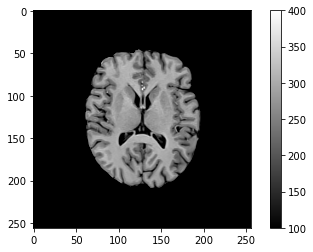

In [3]:
import matplotlib.pyplot as plt
import numpy as np

axial_slice = 88
t1_slice = t1[..., axial_slice]

fig = plt.figure(figsize=(15, 4))
fig.subplots_adjust(wspace=0.2)

t1_slice = np.rot90(t1_slice)

plt.subplot(1, 2, 1)
plt.imshow(t1_slice, cmap='gray', vmin=100, vmax=400)
plt.colorbar()
fig.savefig('structural.png')

Due to the high quality of the data, Gibbs artefacts are not visually evident in this dataset. Therefore, to analyse the benefits of the Gibbs suppression algorithm, Gibbs artefacts are artificially introduced by removing high frequencies of the image’s Fourier transform.

In [4]:
c = np.fft.fft2(t1_slice)
c = np.fft.fftshift(c)
N = c.shape[0]
c_crop = c[64: 192, 64: 192]
N = c_crop.shape[0]
t1_gibbs = abs(np.fft.ifft2(c_crop)/4)

Gibbs oscillation suppression of this single data slice can be performed by running the following command:

In [5]:
t1_unring = gibbs_removal(t1_gibbs, inplace=False)

Let’s plot the results:

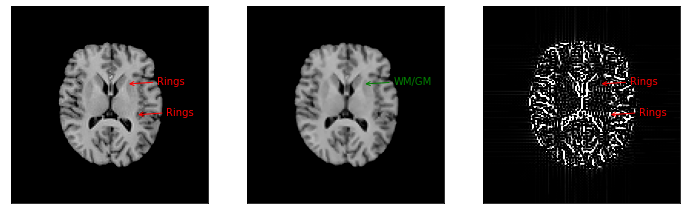

In [6]:
fig1, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(t1_gibbs, cmap="gray", vmin=100, vmax=400)
ax.flat[0].annotate('Rings', fontsize=10, xy=(81, 70),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))
ax.flat[0].annotate('Rings', fontsize=10, xy=(75, 50),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))

ax.flat[1].imshow(t1_unring, cmap="gray", vmin=100, vmax=400)
ax.flat[1].annotate('WM/GM', fontsize=10, xy=(75, 50),
                    color='green',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='green'))

ax.flat[2].imshow(t1_unring - t1_gibbs, cmap="gray", vmin=0, vmax=10)
ax.flat[2].annotate('Rings', fontsize=10, xy=(81, 70),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))
ax.flat[2].annotate('Rings', fontsize=10, xy=(75, 50),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))
plt.show()
fig1.savefig('Gibbs_suppression_structural.png')

The image artificially corrupted with Gibb’s artefacts is shown in the left panel. In this panel, the characteristic ringing profile of Gibbs artefacts can be visually appreciated (see intensity oscillations pointed by the red arrows). The corrected image is shown in the middle panel. One can appreciate that artefactual oscillations are visually suppressed without compromising the contrast between white and grey matter (e.g. details pointed by the green arrow). The difference between uncorrected and corrected data is plotted in the right panel which highlights the suppressed Gibbs ringing profile.

Now let’s show how to use the Gibbs suppression algorithm in diffusion-weighted images.

In [7]:
from dipy.data import read_cenir_multib

bvals = [200, 400, 1000, 2000]

img, gtab = read_cenir_multib(bvals)

data = np.asarray(img.dataobj)

For illustration proposes, we select two slices of this dataset

In [8]:
data_slices = data[:, :, 40:42, :]

Gibbs oscillation suppression of all multi-shell data and all slices can be performed in the following way:

In [9]:
data_corrected = gibbs_removal(data_slices, slice_axis=2, inplace=False, num_threads=None)

Due to the high dimensionality of diffusion-weighted data, we recommend that you specify which is the axis of data matrix that corresponds to different slices in the above step. This is done by using the optional parameter ‘slice_axis’.

Below we plot the results for an image acquired with b-value=0:

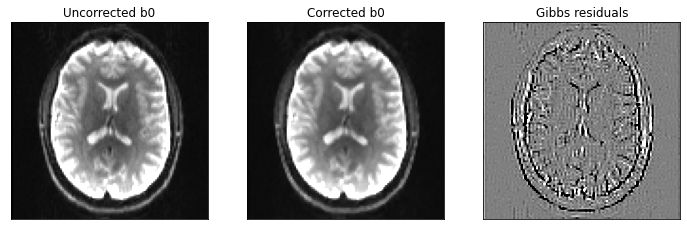

In [10]:
fig2, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(data_slices[:, :, 0, 0].T, cmap='gray', origin='lower',
                  vmin=0, vmax=10000)
ax.flat[0].set_title('Uncorrected b0')
ax.flat[1].imshow(data_corrected[:, :, 0, 0].T, cmap='gray',
                  origin='lower', vmin=0, vmax=10000)
ax.flat[1].set_title('Corrected b0')
ax.flat[2].imshow(data_corrected[:, :, 0, 0].T - data_slices[:, :, 0, 0].T,
                  cmap='gray', origin='lower', vmin=-500, vmax=500)
ax.flat[2].set_title('Gibbs residuals')

plt.show()
fig2.savefig('Gibbs_suppression_b0.png')

The above figure shows that the benefits of suppressing Gibbs artefacts is hard to observe on b-value=0 data. Therefore, diffusion derived metrics for both uncorrected and corrected data are computed using the mean signal diffusion kurtosis image technique

To avoid unnecessary calculations on the background of the image, we also compute a brain mask.

In [11]:
# Create a brain mask
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data_slices, vol_idx=range(10, 50),
                             median_radius=7, numpass=1, autocrop=False,
                             dilate=2)

In [12]:
# Define mean signal diffusion kurtosis model
import dipy.reconst.msdki as msdki

dki_model = msdki.MeanDiffusionKurtosisModel(gtab)

# Fit the uncorrected data
dki_fit = dki_model.fit(data_slices, mask=mask)
MSKini = dki_fit.msk

# Fit the corrected data
dki_fit = dki_model.fit(data_corrected, mask=mask)
MSKgib = dki_fit.msk

Let’s plot the results

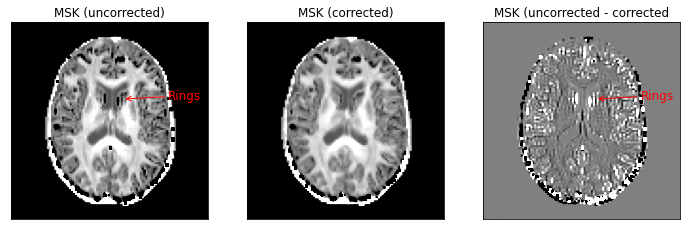

In [13]:
fig3, ax = plt.subplots(1, 3, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(MSKini[:, :, 0].T, cmap='gray', origin='lower',
                  vmin=0, vmax=1.5)
ax.flat[0].set_title('MSK (uncorrected)')
ax.flat[0].annotate('Rings', fontsize=12, xy=(59, 63),
                    color='red',
                    xycoords='data', xytext=(45, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))

ax.flat[1].imshow(MSKgib[:, :, 0].T, cmap='gray', origin='lower',
                  vmin=0, vmax=1.5)
ax.flat[1].set_title('MSK (corrected)')

ax.flat[2].imshow(MSKgib[:, :, 0].T - MSKini[:, :, 0].T, cmap='gray',
                  origin='lower', vmin=-0.2, vmax=0.2)
ax.flat[2].set_title('MSK (uncorrected - corrected')
ax.flat[2].annotate('Rings', fontsize=12, xy=(59, 63),
                    color='red',
                    xycoords='data', xytext=(45, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))

plt.show()
fig3.savefig('Gibbs_suppression_msdki.png')